In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part#0: Import Libraries

In [1]:
# DO NOT RUN THIS UNLESS THEY ARE NOT INSTALLED TO YOUR DEVICE THEN INSTALL THEM FROM THE CONDA COMMAND OR COMMAND PROMPT
# Install Pipelines
!pip install tensorflow==2.17.1
!pip install dlib
!pip install face_recognition --no-cache-dir
!pip install imageio-ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.

In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [2]:
# Cell 1 — patch FaceRecognition to always use the HOG detector, never the CNN one
import face_recognition.api as fr_api

# keep the original HOG detector
_hog_detector = fr_api.face_detector

# override the CNN detector so it points at the HOG detector
fr_api.cnn_face_detector = _hog_detector

# also override the raw face‐location entry point to force model='hog'
_orig_raw = fr_api._raw_face_locations
def _raw_hog(img, number_of_times_to_upsample, model='cnn'):
    # ignore the requested model, always do HOG
    return _orig_raw(img, number_of_times_to_upsample, model='hog')
fr_api._raw_face_locations = _raw_hog


In [3]:
import random
from os import listdir
from os.path import isfile, join
import numpy as np
from math import floor
from scipy.ndimage import zoom, rotate
import imageio
import face_recognition
from tensorflow import keras
#=============2#
from keras._tf_keras.keras.models import Model as KerasModel
from keras._tf_keras.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras._tf_keras.keras.optimizers import Adam
#=============3#
#from pipeline import *
import requests  # added to run the github code
import os  # added also to run the github code
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
#=============4#
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
#=============5#
from keras._tf_keras.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.models import Model

# Part#1 Baseline Model

In [4]:
import os, requests

# directory where you want all the *.h5 files
weights_dir = "weights"
os.makedirs(weights_dir, exist_ok=True)

URLS = {
    "Meso4_F2F.h5"        : "https://github.com/DariusAf/MesoNet/raw/master/weights/Meso4_F2F.h5",
    "Meso4_DF.h5"         : "https://github.com/DariusAf/MesoNet/raw/master/weights/Meso4_DF.h5",
    "MesoInception_F2F.h5": "https://github.com/DariusAf/MesoNet/raw/master/weights/MesoInception_F2F.h5",
    "MesoInception_DF.h5" : "https://github.com/DariusAf/MesoNet/raw/master/weights/MesoInception_DF.h5",
}

for fname, url in URLS.items():
    fpath = os.path.join(weights_dir, fname)
    if not os.path.exists(fpath):
        print(f"⬇  downloading {fname}")
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(fpath, "wb") as fh:
            for chunk in r.iter_content(8192):
                fh.write(chunk)
    else:
        print(f"✓ {fname} already present")


⬇  downloading Meso4_F2F.h5
⬇  downloading Meso4_DF.h5
⬇  downloading MesoInception_F2F.h5
⬇  downloading MesoInception_DF.h5


In [5]:
# -*- coding:utf-8 -*-
'''
Note to me:
This Python code performs face detection, face alignment, and face classification from videos
This script is designed for automatic face recognition in videos. It detects and aligns faces, extracts face patches,
and then uses a classifier to analyze them. The goal could be facial identity recognition, emotion analysis,
or deepfake detection, depending on the classifier used.
'''

## Face extraction

class Video:
    '''
    Note to me
    This is a Video Handeling class, which is used to:
    1. Loads a video using imageio.
    2. Retrieves frames using get() and next_frame().
    3. Extracts metadata like frame rate (fps) and total frames.
    '''
    def __init__(self, path):
        #Initialization (__init__): When an instance is created of this class,
        #it takes the path to the video file and loads the video using imageio.
        #It also counts the total frames and gets the frame rate (fps).
        self.path = path
        self.container = imageio.get_reader(path, 'ffmpeg')
        self.length = self.container.count_frames()
        self.fps = self.container.get_meta_data()['fps']

    def init_head(self):
        self.container.set_image_index(0)

    def next_frame(self): #Retrieves the next frame from the video.
        self.container.get_next_data()

    def get(self, key): #Gets a specific frame based on its index.
        return self.container.get_data(key)

    def __call__(self, key):
        return self.get(key)

    def __len__(self): #Returns the total number of frames in the video.
        return self.length


class FaceFinder(Video):
    '''
    Note to me
    This is Face Detection and Alignment Class, which is used to:
    1. Extends Video class to detect faces in video frames using face_recognition.face_locations().
    2. Uses expand_location_zone() to add a margin around detected faces.
    3. Determines face center, size, and rotation using facial landmarks.
    4. Uses zoom() for downsampling frames to speed up face detection.
    5. Aligns faces by rotating and cropping them.
    '''
    def __init__(self, path, load_first_face=True):
        super().__init__(path)
        self.faces = {}
        self.coordinates = {}  # stores the face (locations center, rotation, length)
        self.last_frame = self.get(0)
        self.frame_shape = self.last_frame.shape[:2]
        self.last_location = (0, 200, 200, 0)
        if (load_first_face):
            face_positions = face_recognition.face_locations(self.last_frame, number_of_times_to_upsample=2)
            if len(face_positions) > 0:
                self.last_location = face_positions[0]

    def load_coordinates(self, filename):
        np_coords = np.load(filename)
        self.coordinates = np_coords.item()

    #Adds a margin around detected faces to allow for better alignment.
    def expand_location_zone(self, loc, margin=0.2):
        '''Adds a margin around a frame slice'''
        offset = round(margin * (loc[2] - loc[0]))
        y0 = max(loc[0] - offset, 0)
        x1 = min(loc[1] + offset, self.frame_shape[1])
        y1 = min(loc[2] + offset, self.frame_shape[0])
        x0 = max(loc[3] - offset, 0)
        return (y0, x1, y1, x0)

    @staticmethod
    def upsample_location(reduced_location, upsampled_origin, factor):
        '''Adapt a location to an upsampled image slice'''
        y0, x1, y1, x0 = reduced_location
        Y0 = round(upsampled_origin[0] + y0 * factor)
        X1 = round(upsampled_origin[1] + x1 * factor)
        Y1 = round(upsampled_origin[0] + y1 * factor)
        X0 = round(upsampled_origin[1] + x0 * factor)
        return (Y0, X1, Y1, X0)

    @staticmethod
    def pop_largest_location(location_list):
        max_location = location_list[0]
        max_size = 0
        if len(location_list) > 1:
            for location in location_list:
                size = location[2] - location[0]
                if size > max_size:
                    max_size = size
                    max_location = location
        return max_location

    @staticmethod
    def L2(A, B):
        return np.sqrt(np.sum(np.square(A - B)))
    #Calculates the center, size, and rotation of the detected faces based on facial landmarks (like eyes and mouth).
    def find_coordinates(self, landmark, K=2.2):
        '''
        We either choose K * distance(eyes, mouth),
        or, if the head is tilted, K * distance(eye 1, eye 2)
        /!\ landmarks coordinates are in (x,y) not (y,x)
        '''
        E1 = np.mean(landmark['left_eye'], axis=0)
        E2 = np.mean(landmark['right_eye'], axis=0)
        E = (E1 + E2) / 2
        N = np.mean(landmark['nose_tip'], axis=0) / 2 + np.mean(landmark['nose_bridge'], axis=0) / 2
        B1 = np.mean(landmark['top_lip'], axis=0)
        B2 = np.mean(landmark['bottom_lip'], axis=0)
        B = (B1 + B2) / 2

        C = N
        l1 = self.L2(E1, E2)
        l2 = self.L2(B, E)
        l = max(l1, l2) * K
        if (B[1] == E[1]):
            if (B[0] > E[0]):
                rot = 90
            else:
                rot = -90
        else:
            rot = np.arctan((B[0] - E[0]) / (B[1] - E[1])) / np.pi * 180

        return ((floor(C[1]), floor(C[0])), floor(l), rot)


    def find_faces(self, resize=0.5, stop=0, skipstep=0, no_face_acceleration_threshold=3,
                  cut_left=0, cut_right=-1, use_frameset=False, frameset=[]):
        '''
        The core function to extract faces from frames
        using previous frame location and downsampling to accelerate the loop.
        '''
        not_found = 0
        no_face = 0
        no_face_acc = 0

        # to only deal with a subset of a video, for instance I-frames only
        if (use_frameset):
            finder_frameset = frameset
        else:
            if (stop != 0):
                finder_frameset = range(0, min(self.length, stop), skipstep + 1)
            else:
                finder_frameset = range(0, self.length, skipstep + 1)

        # Quick face finder loop
        #On the very first frame we try to find a face (using the CNN model from the open‑source face_recognition package).
        #If we find one we remember its coordinates – that becomes our starting guess for the next frame.
        '''
        Main loop (find_faces)
For every Nth frame (controlled by skipstep):
Look where we last saw a face (much faster than scanning the whole image).
If nothing is there, gradually fall back to a full‑frame search.
Optionally down‑sample big frames first (resize) to speed things up.
When a face is found we: 1- Store its bounding box (self.faces[i]). 2-Extract 68 facial landmarks (eyes, nose, mouth).
3-From those, compute three numbers: centre C, size L (how “big” the face is) and rotation R (tilt angle of the head).
We save them in self.coordinates[i].
        '''
        for i in finder_frameset:
            # Get frame
            frame = self.get(i)
            if (cut_left != 0 or cut_right != -1):
                frame[:, :cut_left] = 0
                frame[:, cut_right:] = 0

            # Find face in the previously found zone
            potential_location = self.expand_location_zone(self.last_location)
            potential_face_patch = frame[potential_location[0]:potential_location[2], potential_location[3]:potential_location[1]]
            potential_face_patch_origin = (potential_location[0], potential_location[3])

            reduced_potential_face_patch = zoom(potential_face_patch, (resize, resize, 1))
            reduced_face_locations = face_recognition.face_locations(reduced_potential_face_patch, model='cnn')

            if len(reduced_face_locations) > 0:
                no_face_acc = 0  # reset the no_face_acceleration mode accumulator

                reduced_face_location = self.pop_largest_location(reduced_face_locations)
                face_location = self.upsample_location(reduced_face_location,
                                                    potential_face_patch_origin,
                                                    1 / resize)
                self.faces[i] = face_location
                self.last_location = face_location

                # extract face rotation, length and center from landmarks
                landmarks = face_recognition.face_landmarks(frame, [face_location])
                if len(landmarks) > 0:
                    # we assume that there is one and only one landmark group
                    self.coordinates[i] = self.find_coordinates(landmarks[0])
            else:
                not_found += 1

                if no_face_acc < no_face_acceleration_threshold:
                    # Look for face in full frame
                    face_locations = face_recognition.face_locations(frame, number_of_times_to_upsample=2)
                else:
                    # Avoid spending to much time on a long scene without faces
                    reduced_frame = zoom(frame, (resize, resize, 1))
                    face_locations = face_recognition.face_locations(reduced_frame)

                if len(face_locations) > 0:
                    print('Face extraction warning : ', i, '- found face in full frame', face_locations)
                    no_face_acc = 0  # reset the no_face_acceleration mode accumulator

                    face_location = self.pop_largest_location(face_locations)

                    # if was found on a reduced frame, upsample location
                    if no_face_acc > no_face_acceleration_threshold:
                        face_location = self.upsample_location(face_location, (0, 0), 1 / resize)

                    self.faces[i] = face_location
                    self.last_location = face_location
                    # extract face rotation, length and center from landmarks
                    landmarks = face_recognition.face_landmarks(frame, [face_location])
                    if len(landmarks) > 0:
                        self.coordinates[i] = self.find_coordinates(landmarks[0])
                else:
                    print('Face extraction warning : ', i, '- no face')
                    no_face_acc += 1
                    no_face += 1

        print('Face extraction report of', 'not_found :', not_found)
        print('Face extraction report of', 'no_face :', no_face)
        return 0

    def get_face(self, i):
        '''Basic unused face extraction without alignment'''
        frame = self.get(i)
        if i in self.faces:
            loc = self.faces[i]
            patch = frame[loc[0]:loc[2], loc[3]:loc[1]]
            return patch
        return frame

    @staticmethod
    def get_image_slice(img, y0, y1, x0, x1):
        '''Get values outside the domain of an image'''
        m, n = img.shape[:2]
        padding = max(-y0, y1-m, -x0, x1-n, 0)
        padded_img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'reflect')
        return padded_img[(padding + y0):(padding + y1),
                        (padding + x0):(padding + x1)]

    #Why alignment? CNNs learn better when the eyes, nose and mouth are always roughly in the same pixel region.
    def get_aligned_face(self, i, l_factor=1.3):
        '''
        The second core function that converts the data from self.coordinates into an face image.
        '''
        frame = self.get(i)
        if i in self.coordinates:
            c, l, r = self.coordinates[i]
            l = int(l) * l_factor  # fine-tuning the face zoom we really want
            dl_ = floor(np.sqrt(2) * l / 2)  # largest zone even when rotated
            patch = self.get_image_slice(frame,
                                    floor(c[0] - dl_),
                                    floor(c[0] + dl_),
                                    floor(c[1] - dl_),
                                    floor(c[1] + dl_))
            rotated_patch = rotate(patch, -r, reshape=False)
            # note: dl_ is the center of the patch of length 2dl_
            return self.get_image_slice(rotated_patch,
                                    floor(dl_-l//2),
                                    floor(dl_+l//2),
                                    floor(dl_-l//2),
                                    floor(dl_+l//2))
        return frame


## Face prediction
class FaceBatchGenerator:
    '''
    Made to deal with framesubsets of video.
    Note to me:
    This is a Batch Face Extraction class, which is used to:
    1. Extracts and resizes aligned face patches from frames.
    2. Stores faces in batches for classification.
    '''
    #Initialization: Takes an instance of FaceFinder to access detected faces.
    def __init__(self, face_finder, target_size=256):
        self.finder = face_finder
        self.target_size = target_size
        self.head = 0
        self.length = int(face_finder.length)

    def resize_patch(self, patch):
        m, n = patch.shape[:2]
        return zoom(patch, (self.target_size / m, self.target_size / n, 1))
    #Gathers a batch of face images, resizing them to a specified target size for the classifier.
    def next_batch(self, batch_size=50):
        batch = np.zeros((1, self.target_size, self.target_size, 3))
        stop = min(self.head + batch_size, self.length)
        i = 0
        while (i < batch_size) and (self.head < self.length):
            if self.head in self.finder.coordinates:
                patch = self.finder.get_aligned_face(self.head)
                batch = np.concatenate((batch, np.expand_dims(self.resize_patch(patch), axis=0)),
                                      axis=0)
                i += 1
            self.head += 1
        return batch[1:]


def predict_faces(generator, classifier, batch_size=50, output_size=1):
    '''
    Compute predictions for a face batch generator

    Note to me:
    1. Passes extracted face batches to a classifier (assumed to be a deep learning model).
    2. Predicts face attributes or identity.
    '''
    #Loop over all batches: The MesoNet model (Meso4, MesoInception4, …) outputs a probability:1 = real / 0 = fake.
    #Collect all these numbers into one long list: the profile of the video.
    n = len(generator.finder.coordinates.items())
    profile = np.zeros((1, output_size))
    for epoch in range(n // batch_size + 1):
        face_batch = generator.next_batch(batch_size=batch_size)
        prediction = classifier.predict(face_batch)
        if (len(prediction) > 0):
            profile = np.concatenate((profile, prediction))
    return profile[1:]


def compute_accuracy(classifier, dirname, frame_subsample_count=30):
    '''
    Extraction + Prediction over a video

    Note to me:
    1. Processes all videos in a directory.
    2. Extracts faces and makes predictions.
    3. Computes the average classification accuracy for each video.
    '''
    filenames = [f for f in listdir(dirname) if isfile(join(dirname, f)) and ((f[-4:] == '.mp4') or (f[-4:] == '.avi') or (f[-4:] == '.mov'))]
    predictions = {}

    for vid in filenames:
        print('Dealing with video ', vid)

        # Compute face locations and store them in the face finder
        face_finder = FaceFinder(join(dirname, vid), load_first_face=False)
        skipstep = max(floor(face_finder.length / frame_subsample_count), 0)
        face_finder.find_faces(resize=0.5, skipstep=skipstep)

        print('Predicting ', vid)
        gen = FaceBatchGenerator(face_finder)
        p = predict_faces(gen, classifier)

        predictions[vid[:-4]] = (np.mean(p > 0.5), p) #Take the mean of all face probabilities. If that mean ≥ 0.5 → label the whole video as “real” otherwise “fake”.
        #Save (decision, all_face_probs) in a dictionary.
    return predictions

In [6]:
# Classification Model (Meso1, Meso4, MesoInception4), binary classification (sigmoid) to identify fake from real
# -*- coding:utf-8 -*-

IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0

    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)


class Meso1(Classifier):
    """
    Feature extraction + Classification

    Note to me, this function is used to:
    1. A lightweight CNN with two convolutional layers and max-pooling.
    2. Uses a simple feature extraction method.
    3. Ends with a fully connected (Dense) layer and a sigmoid activation for binary classification.
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)


class Meso4(Classifier):
    '''
    Note to me, this function is used to:
    1. A deeper CNN with four convolutional layers, each followed by batch normalization and max-pooling.
    2. Uses LeakyReLU activation in the fully connected layers for better gradient flow.
    3. More complex than Meso1, making it potentially more effective for feature extraction.
    '''
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(negative_slope=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


class MesoInception4(Classifier):
    '''
    Note to me, this function is used to:
    1. Uses an Inception-like architecture, meaning it extracts multi-scale features using different filter sizes.
    2. The InceptionLayer function stacks multiple convolutional paths with different dilation rates to capture various image details.
    3. It incorporates elements from Google's Inception models, making it more powerful than Meso4.
    '''
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)

            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)

            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)

            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])

            return y
        return func

    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))

        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)

        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)

        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)

        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(negative_slope=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [7]:
# Given Example

# Get the weight files from GitHub
weights_files = {
    'Meso4_DF.h5': 'https://github.com/DariusAf/MesoNet/raw/master/weights/Meso4_DF.h5',
    'Meso4_F2F.h5': 'https://github.com/DariusAf/MesoNet/raw/master/weights/Meso4_F2F.h5'
}

# Local directory to save the weights files
weights_dir = 'weights'
os.makedirs(weights_dir, exist_ok=True)  # Create the 'weights' directory if it doesn't exist

# Download each weights file
for file_name, url in weights_files.items():
    file_path = os.path.join(weights_dir, file_name)
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)
      #  print(f"Downloaded {file_name} to {file_path}")
    else:
        print(f"Failed to download {file_name}. Status code: {response.status_code}")

# Get the test images from Github
# Base URL of the test_images folder on GitHub
base_url = 'https://github.com/DariusAf/MesoNet/raw/master/test_images'

# List of files to download (replace with actual file names)
files = [
    'real/real00240.jpg',
    'real/real00772.jpg',
    'df/df00204.jpg',
    'df/df01254.jpg'
]

# Local directory to save the test images
test_images_dir = 'test_images'

# Download each file
for file in files:
    # Create the subdirectory if it doesn't exist
    subdirectory = os.path.join(test_images_dir, os.path.dirname(file))
    os.makedirs(subdirectory, exist_ok=True)

    # Construct the full file path
    file_path = os.path.join(test_images_dir, file)

    # Download the file
    url = f"{base_url}/{file}"
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)
        #print(f"Downloaded {file} to {file_path}")
    else:
        print(f"Failed to download {file}. Status code: {response.status_code}")

# 1 - Load the model and its pretrained weights
classifier = Meso4()
classifier.load(os.path.join(weights_dir, 'Meso4_DF.h5'))  # Load Meso4_DF.h5

# 2 - Minimal image generator
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
    test_images_dir,
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary',
    subset='training'
)

print("Class mapping:", generator.class_indices)

# 3 - Predict
X, y = next(generator)
print('Predicted :', classifier.predict(X), '\nReal class :', y)


Found 4 images belonging to 2 classes.
Class mapping: {'df': 0, 'real': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicted : [[0.9897476]] 
Real class : [1.]


# Part#2: Exploring and Enhancing the Output of Baseline Model

Found 4 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


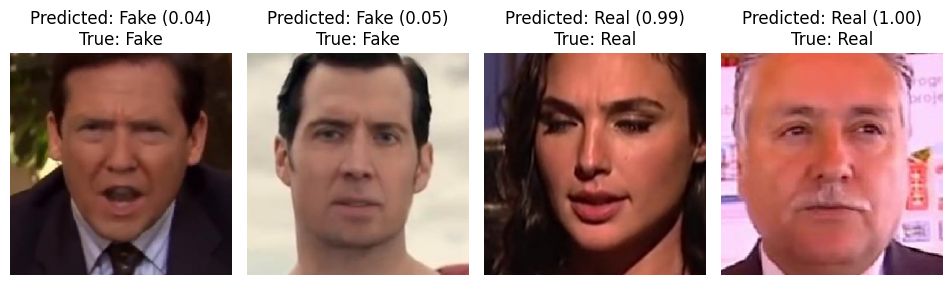

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Test Loss: 0.0010, Test Accuracy: 1.0000

Confusion Matrix:
[[2 0]
 [0 2]]

Classification Report:
              precision    recall  f1-score   support

          df       1.00      1.00      1.00         2
        real       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [8]:
# Load the model and its pretrained weights
classifier = Meso4()
classifier.load(os.path.join(weights_dir, 'Meso4_DF.h5'))  # Load Meso4_DF.h5

class_map = {v: k for k, v in generator.class_indices.items()}

# 2 - Minimal image generator
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
    test_images_dir,
    target_size=(256, 256),
    batch_size=4,
    class_mode='binary',
    shuffle=False,
    subset='training'
)

X_batch, y_batch = next(generator)  # X_batch.shape = (4, 256, 256, 3)
preds = classifier.predict(X_batch)  # Just ONE line "1/1" or one progress bar

###########################
# 2. Visualize Predictions
###########################
plt.figure(figsize=(12, 6))


# We'll just visualize 4 images for demo
for i in range(4):
    pred_prob = preds[i][0]

    # Interpret the true label using class_map
    # Example: if class_map[y_true[0]] == 'df' → "Fake"; else → "Real"
    # Adjust this logic to your folder names if needed.
    if class_map[y_batch[i]] == 'df':
        true_label = "Fake"
    else:
        true_label = "Real"

    # Interpret the predicted label using a threshold of 0.5
    pred_label = "Real" if pred_prob >= 0.5 else "Fake"

    # Plot the image
    plt.subplot(2, 5, i+1)
    plt.imshow(X_batch[i])
    plt.title(f"Predicted: {pred_label} ({pred_prob:.2f})\nTrue: {true_label}")
    #plt.title(f"P: {pred:.2f}\nT: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate loss
score = classifier.model.evaluate(generator, verbose=0)
print(f"\nTest Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

generator.reset()
y_probs = classifier.model.predict(generator, verbose=0)  # Predicted probabilities
y_pred = (y_probs >= 0.5).astype(int).reshape(-1)           # Convert probabilities to binary predictions.
y_true = generator.classes                                # Ground truth labels extracted from the folder structure.

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[class_map[0], class_map[1]]))


Face extraction report of not_found : 0
Face extraction report of no_face : 0


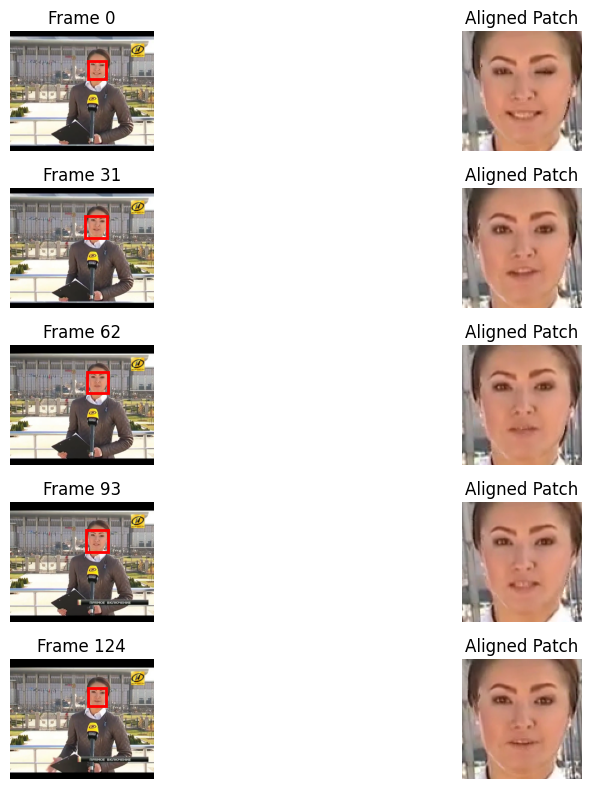

In [9]:
## Testing the pipline extraction of frames from videos
_orig = face_recognition.face_locations
def _hog(img, number_of_times_to_upsample=1, model="hog"):
    return _orig(img, number_of_times_to_upsample, model='hog')
face_recognition.face_locations = _hog

# 2) Pick a sample video (adjust path as needed)
sample_video = '/content/drive/MyDrive/DL_Project/F2FSubset/007_132.mp4'

# 3) Run the finder
finder = FaceFinder(sample_video, load_first_face=True)
finder.find_faces(resize=0.5, skipstep=30)

# 4) Visualize first few detections + aligned patches
idxs = list(finder.faces.keys())[:5]
plt.figure(figsize=(12, 8))

for i, idx in enumerate(idxs):
    frame = finder.get(idx)
    y0, x1, y1, x0 = finder.faces[idx]

    # Raw frame + box
    plt.subplot(5,2,2*i+1)
    plt.imshow(frame)
    plt.gca().add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0,
                                      edgecolor='red', linewidth=2, fill=False))
    plt.title(f"Frame {idx}")
    plt.axis('off')

    # Aligned crop
    plt.subplot(5,2,2*i+2)
    aligned = finder.get_aligned_face(idx)
    plt.imshow(aligned)
    plt.title("Aligned Patch")
    plt.axis('off')

plt.tight_layout()
plt.show()


Face extraction report of not_found : 0
Face extraction report of no_face : 0


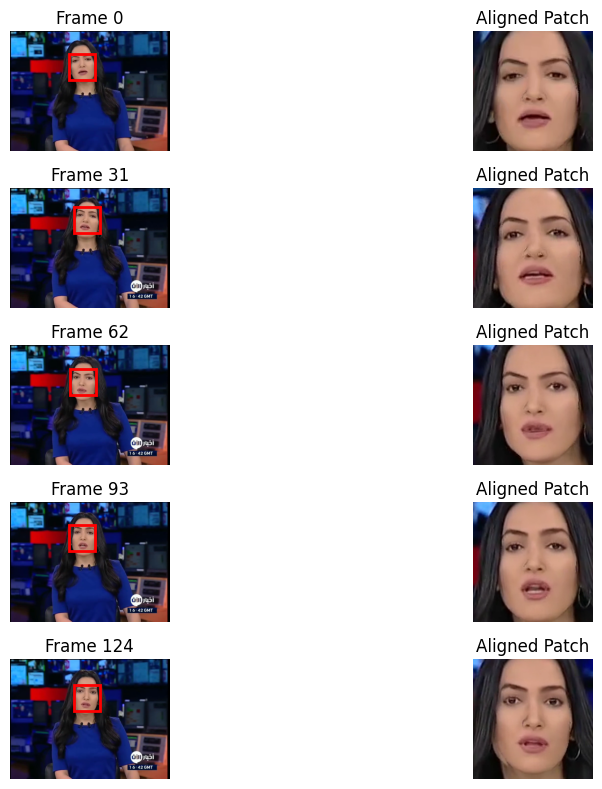

In [ ]:
finder = FaceFinder('/content/drive/MyDrive/DL_Project/F2FSubset/026_012.mp4', load_first_face=True)
finder.find_faces(resize=0.5, skipstep=30)
# pick the first few frame‐indices where faces were found
idxs = sorted(finder.faces.keys())[:5]

plt.figure(figsize=(12, 8))
for i, frame_idx in enumerate(idxs):
    frame = finder.get(frame_idx)
    y0, x1, y1, x0 = finder.faces[frame_idx]

    # 1) raw frame + red box
    ax = plt.subplot(5, 2, 2*i + 1)
    ax.imshow(frame)
    ax.add_patch(plt.Rectangle((x0, y0),
                               x1 - x0, y1 - y0,
                               edgecolor='red',
                               linewidth=2,
                               fill=False))
    ax.set_title(f"Frame {frame_idx}")
    ax.axis('off')

    # 2) aligned & rotated face patch
    ax2 = plt.subplot(5, 2, 2*i + 2)
    aligned = finder.get_aligned_face(frame_idx)
    ax2.imshow(aligned)
    ax2.set_title("Aligned Patch")
    ax2.axis('off')

plt.tight_layout()
plt.show()

Face extraction report of not_found : 0
Face extraction report of no_face : 0


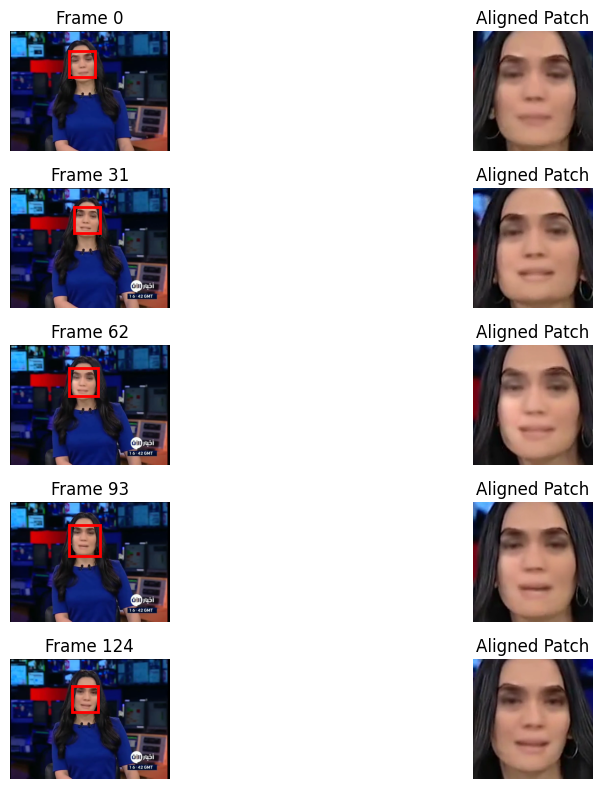

In [ ]:
finder = FaceFinder('/content/drive/MyDrive/DL_Project/DeepFakesSubset/026_012.mp4', load_first_face=True)
finder.find_faces(resize=0.5, skipstep=30)
# pick the first few frame‐indices where faces were found
idxs = sorted(finder.faces.keys())[:5]

plt.figure(figsize=(12, 8))
for i, frame_idx in enumerate(idxs):
    frame = finder.get(frame_idx)
    y0, x1, y1, x0 = finder.faces[frame_idx]

    # 1) raw frame + red box
    ax = plt.subplot(5, 2, 2*i + 1)
    ax.imshow(frame)
    ax.add_patch(plt.Rectangle((x0, y0),
                               x1 - x0, y1 - y0,
                               edgecolor='red',
                               linewidth=2,
                               fill=False))
    ax.set_title(f"Frame {frame_idx}")
    ax.axis('off')

    # 2) aligned & rotated face patch
    ax2 = plt.subplot(5, 2, 2*i + 2)
    aligned = finder.get_aligned_face(frame_idx)
    ax2.imshow(aligned)
    ax2.set_title("Aligned Patch")
    ax2.axis('off')

plt.tight_layout()
plt.show()


================  DATASET : F2F  (fake‑only)  ================

▶ MesoInception4 | weights: MesoInception_F2F.h5
   Testing FAKE videos in →  /content/drive/MyDrive/DL_Project/F2FSubset
Dealing with video  016_209.mp4
Face extraction warning :  0 - found face in full frame [(100, 314, 177, 237)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  016_209.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Dealing with video  024_073.mp4
Face extraction warning :  0 - found face in full frame [(102, 440, 263, 280), (220, 392, 298, 314)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  024_073.mp4


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Dealing with video  062_066.mp4
Face extraction report of not_found : 0
Face extraction report of no_face : 0
Predicting  062_066.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Dealing with video  033_097.mp4
Face extraction warning :  0 - found face in full frame [(69, 426, 133, 362), (201, 163, 238, 126)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  033_097.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Dealing with video  021_312.mp4
Face extraction warning :  0 - found face in full frame [(126, 340, 191, 276)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  021_312.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Dealing with video  104_126.mp4
Face extraction warning :  0 - found face in full frame [(102, 405, 263, 244)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  104_126.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Dealing wit

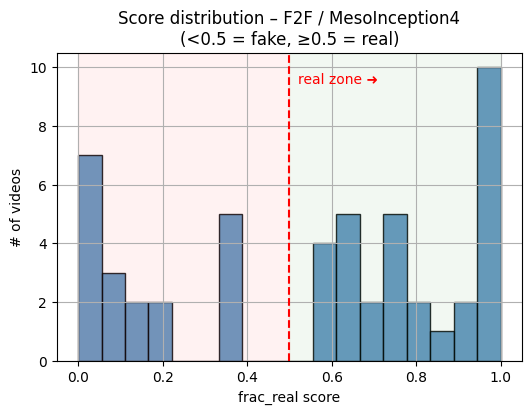

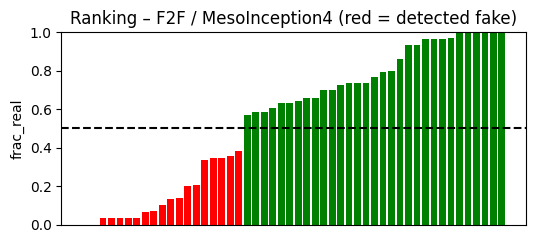


▶ Meso4 | weights: Meso4_F2F.h5
   Testing FAKE videos in →  /content/drive/MyDrive/DL_Project/F2FSubset
Dealing with video  016_209.mp4
Face extraction warning :  0 - found face in full frame [(100, 314, 177, 237)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  016_209.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Dealing with video  024_073.mp4
Face extraction warning :  0 - found face in full frame [(102, 440, 263, 280), (220, 392, 298, 314)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  024_073.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Dealing with video  062_066.mp4
Face extraction report of not_found : 0
Face extraction report of no_face : 0
Predicting  062_066.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Dealing with video  033_097.mp4
Face extraction warning :  0 - found face in full frame [(69, 426, 133, 362), (201, 163, 238, 126)]
Face extraction report of not_found : 1
Face extraction report 

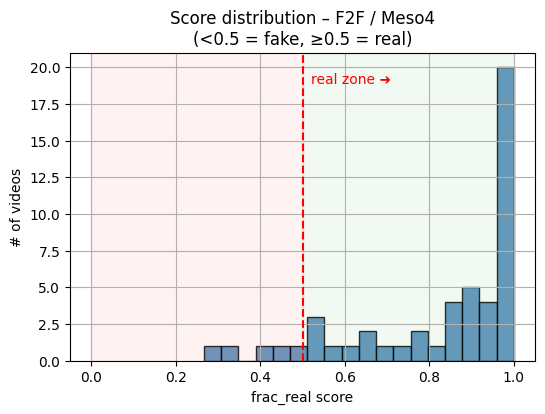

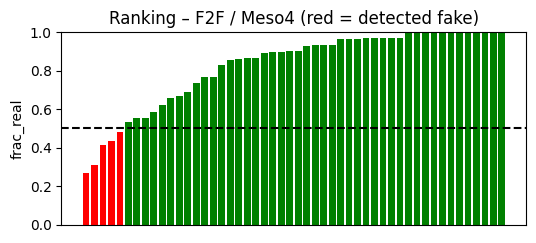


================  DATASET : DF  (fake‑only)  ================

▶ MesoInception4 | weights: MesoInception_DF.h5
   Testing FAKE videos in →  /content/drive/MyDrive/DL_Project/Benchmark_Test_VIDs
Dealing with video  024_073.mp4
Face extraction warning :  0 - found face in full frame [(102, 440, 263, 280)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  024_073.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Dealing with video  070_057.mp4
Face extraction warning :  0 - found face in full frame [(108, 317, 219, 206)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  070_057.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Dealing with video  082_103.mp4
Face extraction warning :  0 - found face in full frame [(95, 367, 207, 255)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  082_103.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Dealing with video  072_037.mp4
Face extraction wa

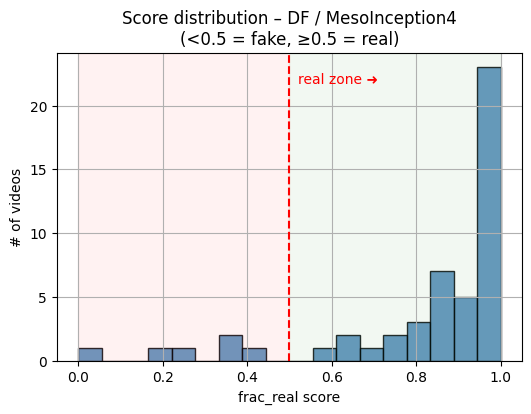

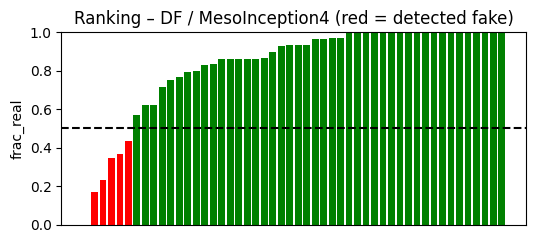


▶ Meso4 | weights: Meso4_DF.h5
   Testing FAKE videos in →  /content/drive/MyDrive/DL_Project/Benchmark_Test_VIDs
Dealing with video  024_073.mp4
Face extraction warning :  0 - found face in full frame [(102, 440, 263, 280)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  024_073.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Dealing with video  070_057.mp4
Face extraction warning :  0 - found face in full frame [(108, 317, 219, 206)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  070_057.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Dealing with video  082_103.mp4
Face extraction warning :  0 - found face in full frame [(95, 367, 207, 255)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  082_103.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Dealing with video  072_037.mp4
Face extraction warning :  0 - found face in full frame [(131, 378, 224, 285)]
Face extraction rep

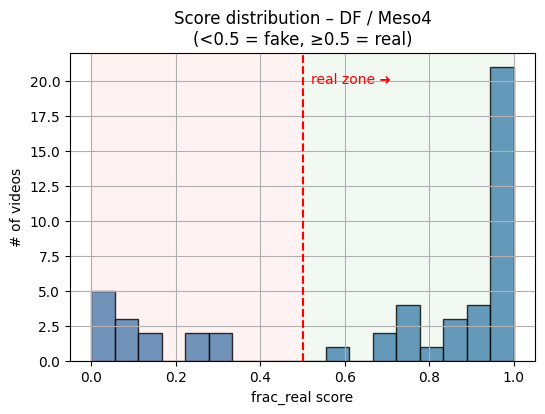

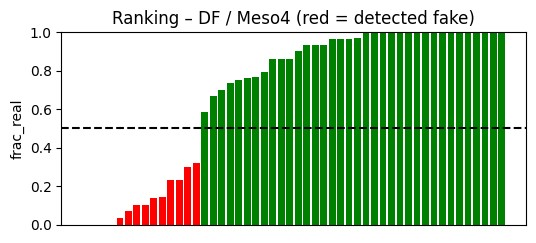


================  QUICK LOOK  – F2F  ================

▶ Visualising frames from 161_141.mp4
Face extraction warning :  0 - found face in full frame [(95, 392, 207, 280)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


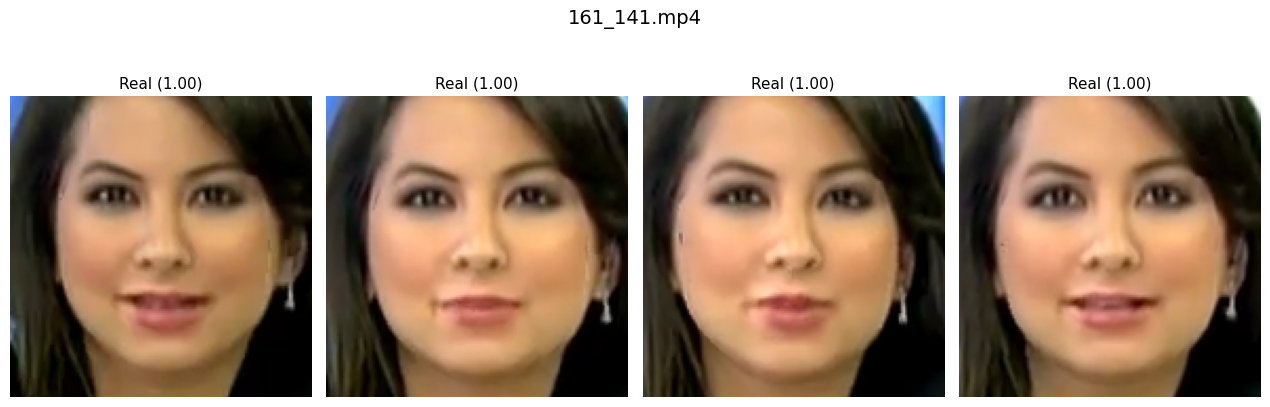


▶ Visualising frames from 013_883.mp4
Face extraction warning :  0 - found face in full frame [(120, 404, 231, 293)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


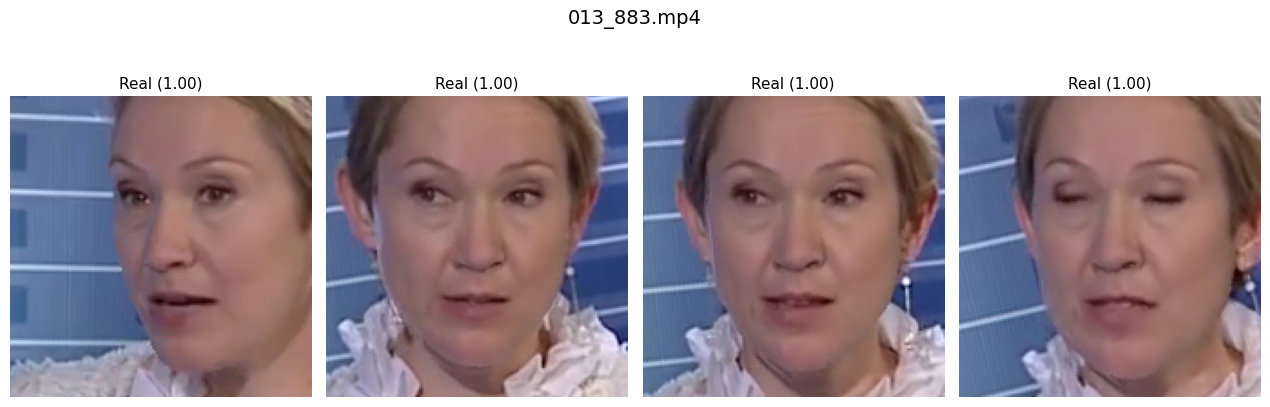


▶ Visualising frames from 026_012.mp4
Face extraction warning :  0 - found face in full frame [(83, 342, 194, 231)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


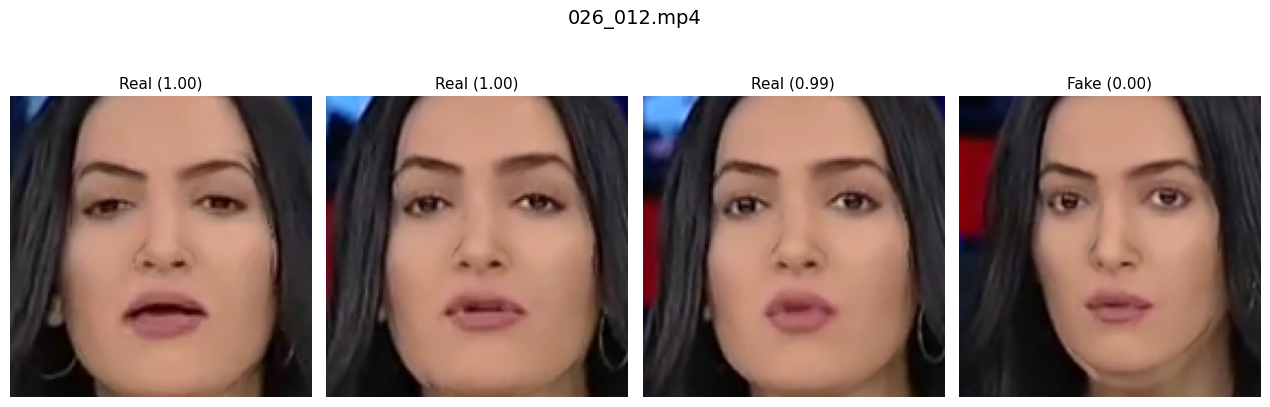


================  QUICK LOOK  – DF  ================

▶ Visualising frames from 385_414.mp4
Face extraction warning :  0 - found face in full frame [(85, 732, 362, 454)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


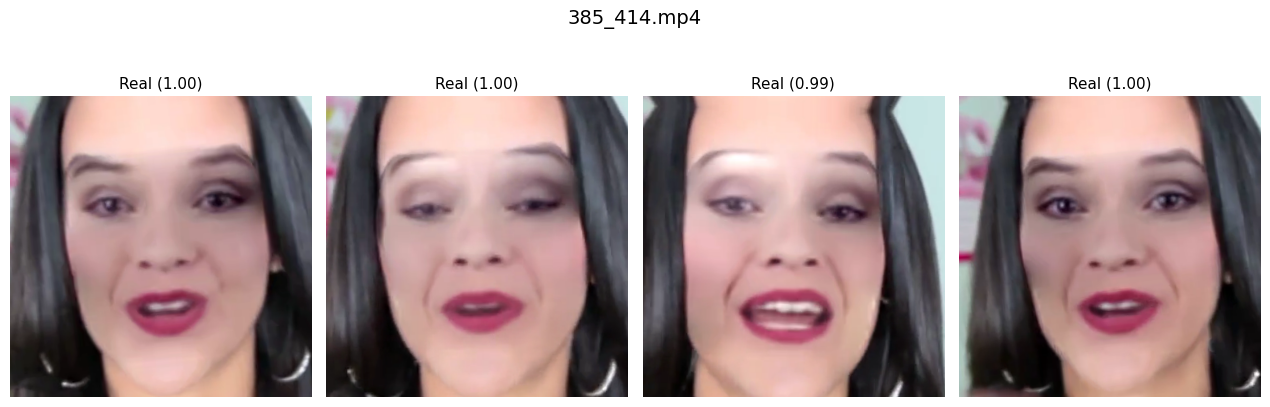


▶ Visualising frames from 622_647.mp4
Face extraction warning :  0 - found face in full frame [(120, 743, 280, 583)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


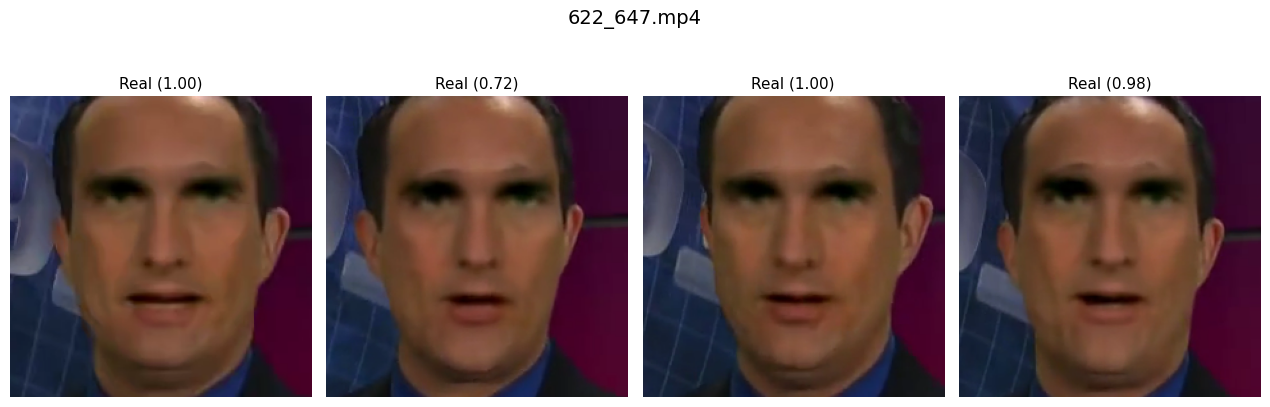


▶ Visualising frames from 257_420.mp4
Face extraction warning :  0 - found face in full frame [(162, 505, 226, 441)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


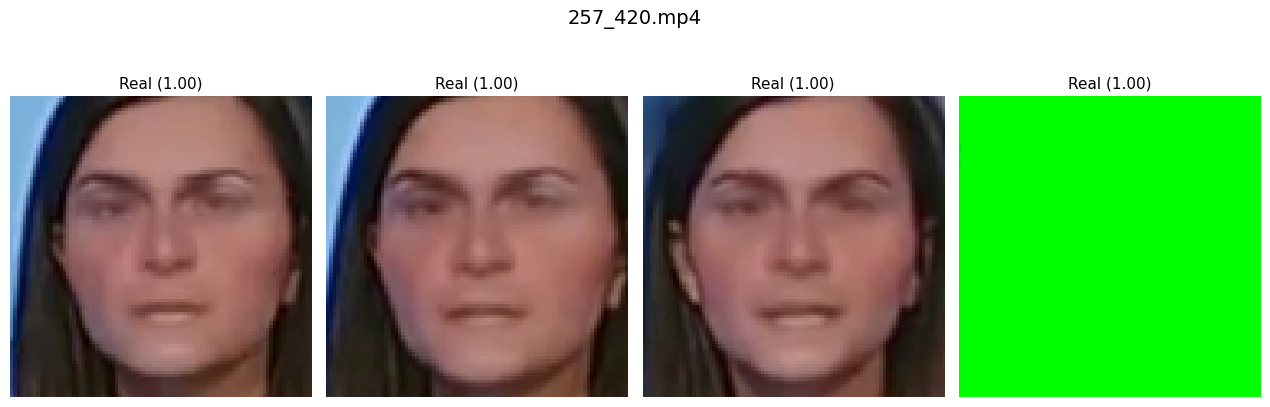


================  OVERALL SUMMARY  =================
set │ model            │ weights                │ fake%
-------------------------------------------------------
F2F │ MesoInception4  │ MesoInception_F2F.h5   │  38.0%
F2F │ Meso4           │ Meso4_F2F.h5           │  10.0%
DF  │ MesoInception4  │ MesoInception_DF.h5    │  12.0%
DF  │ Meso4           │ Meso4_DF.h5            │  28.0%


In [10]:
# ──────────────────────────────────────────────────────────────
# 0 ▸  Imports
# ──────────────────────────────────────────────────────────────
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ──────────────────────────────────────────────────────────────
# 1 ▸  Fake‑only evaluation helper
#     – returns the raw scores so we can build violin / box plots later
# ──────────────────────────────────────────────────────────────
def eval_fake_only(model_class, weight_file, fake_dir,
                   thresh=0.5, title_tag=""):

    # load network
    net = model_class()
    net.load(weight_file)
    print(f"\n▶ {model_class.__name__} | weights: {os.path.basename(weight_file)}")
    print(f"   Testing FAKE videos in →  {fake_dir}")

    #inference via the original author’s pipeline
    pred_fake   = compute_accuracy(net, fake_dir)        # {stem: (frac_real, frame_preds)}
    scores      = np.array([frac for frac, _ in pred_fake.values()])
    video_names = list(pred_fake.keys())


    y_pred = (scores >= thresh).astype(int)              # 0=fake, 1=real
    detected_fake = np.sum(y_pred == 0)
    fake_pct      = 100*detected_fake/len(scores)


    print("\nTABLE – per‑video results")
    print("video".ljust(25),"│ frac_real │ predicted")
    print("-"*50)
    for v, s, p in zip(video_names, scores, y_pred):
        lbl = "fake" if p == 0 else "real"
        print(v.ljust(25),f"│  {s:8.3f} │ {lbl}")

    print(f"\nDetected fake videos (<{thresh}): "
          f"{fake_pct:.1f}% ({detected_fake}/{len(scores)})\n")


    plt.figure(figsize=(6,4))
    plt.hist(scores, bins=18, color='steelblue', alpha=.8, edgecolor='k')


    plt.axvline(thresh, c='r', ls='--')
    plt.text(thresh+0.02, plt.ylim()[1]*0.9, "real zone ➜", color='r')


    plt.axvspan(0, thresh,   color='red',   alpha=0.05)   # fake side
    plt.axvspan(thresh, 1,   color='green', alpha=0.05)   # real side

    plt.xlabel("frac_real score")
    plt.ylabel("# of videos")
    plt.title(f"Score distribution – {title_tag}\n(<{thresh} = fake, ≥{thresh} = real)")
    plt.grid(True)
    plt.show()



    idx = np.argsort(scores)                    # low → high
    colors = ["red" if s < thresh else "green" for s in scores[idx]]
    plt.figure(figsize=(6,2.5))
    plt.bar(range(len(scores)), scores[idx], color=colors)
    plt.axhline(thresh, c='k', ls='--'); plt.ylim(0,1)
    plt.xticks([]); plt.ylabel("frac_real")
    plt.title(f"Ranking – {title_tag} (red = detected fake)"); plt.show()


    return dict(dataset = title_tag.split(" / ")[0],
                model   = model_class.__name__,
                weights = os.path.basename(weight_file),
                fake_pct= fake_pct,
                scores  = scores)

# ──────────────────────────────────────────────────────────────
# 2 ▸  DATASET CONFIG  –  edit paths once
# ──────────────────────────────────────────────────────────────
DATASETS = {
    "F2F" : dict(fake_dir="/content/drive/MyDrive/DL_Project/F2FSubset",
                 m4_w="weights/Meso4_F2F.h5",
                 mi_w="weights/MesoInception_F2F.h5"),

    "DF"  : dict(fake_dir="/content/drive/MyDrive/DL_Project/Benchmark_Test_VIDs",
                 m4_w="weights/Meso4_DF.h5",
                 mi_w="weights/MesoInception_DF.h5"),
}

# ──────────────────────────────────────────────────────────────
# 3 ▸  RUN  – collect results
# ──────────────────────────────────────────────────────────────
all_results = []          # store dicts with scores for later violin plot

for tag, cfg in DATASETS.items():
    print(f"\n================  DATASET : {tag}  (fake‑only)  ================")

    all_results.append(
        eval_fake_only(MesoInception4, cfg['mi_w'],
                       cfg['fake_dir'],
                       title_tag=f"{tag} / MesoInception4")
    )

    all_results.append(
        eval_fake_only(Meso4, cfg['m4_w'],
                       cfg['fake_dir'],
                       title_tag=f"{tag} / Meso4")
    )

# ──────────────────────────────────────────────────────────────
# 5 ▸  QUICK-LOOK VISUALISER  – per-frame scores for a few videos
# ──────────────────────────────────────────────────────────────
import math, random, matplotlib.pyplot as plt

def show_video_frames(video_paths, classifier, thresh=0.5, max_frames=4):
    """
    Parameters
    ----------
    video_paths : list[str]
        Full paths of the videos you want to visualise.
    classifier  : a loaded Meso4 / MesoInception4 object (already has weights).
    thresh      : decision threshold (0.5 by default).
    max_frames  : how many face-patches to show per video.
    """

    for vid in video_paths:
        print(f"\n▶ Visualising frames from {os.path.basename(vid)}")
        ff   = FaceFinder(vid, load_first_face=False)
        ff.find_faces(resize=0.5, skipstep=max(1, ff.length//60))  # ~60 calls max

        # -------- get predictions on *all* extracted faces ---------------
        gen   = FaceBatchGenerator(ff)
        preds = predict_faces(gen, classifier).flatten()  # probability of 'real'

        # ------- pick evenly-spaced sample of frames --------------------
        frame_idxs = sorted(ff.coordinates.keys())
        if not frame_idxs:
            print("   (no faces detected)")
            continue
        step   = max(1, len(frame_idxs)//max_frames)
        chosen = frame_idxs[::step][:max_frames]

        # ---------- plotting --------------------------------------------
        n = len(chosen)
        plt.figure(figsize=(3.2*n, 4))

        for i, idx in enumerate(chosen):
            patch = ff.get_aligned_face(idx)
            score = preds[np.where(np.array(frame_idxs)==idx)[0][0]]
            label = "Real" if score >= thresh else "Fake"

            plt.subplot(1,n,i+1)
            plt.imshow(patch); plt.axis('off')
            plt.title(f"{label} ({score:.2f})", fontsize=11)

        plt.suptitle(os.path.basename(vid), y=1.05, fontsize=14)
        plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────
# 6 ▸  CALL IT – pick 2-3 random videos from each fake folder
# ──────────────────────────────────────────────────────────────
random.seed(0)   #  reproducible sampling

for tag, cfg in DATASETS.items():
    sample_paths = random.sample(
        [os.path.join(cfg['fake_dir'], v) for v in os.listdir(cfg['fake_dir'])
         if v.lower().endswith(('.mp4','.avi','.mov'))],
        k = min(3, len(os.listdir(cfg['fake_dir'])))      # at most 3
    )

    print(f"\n================  QUICK LOOK  – {tag}  ================")

    # choose which network you want to visualise (here Meso4 with its weights)
    net = Meso4()
    net.load(cfg['m4_w'])          # or cfg['mi_w'] for MesoInception4

    show_video_frames(sample_paths, net, thresh=0.5, max_frames=4)


# ──────────────────────────────────────────────────────────────
# 4 ▸  GRAND SUMMARY TABLE
# ──────────────────────────────────────────────────────────────
print("\n================  OVERALL SUMMARY  =================")
print("set │ model            │ weights                │ fake%")
print("-"*55)
for row in all_results:
    print(f"{row['dataset']:3s} │ {row['model']:<15s} │ "
          f"{row['weights']:<22s} │ {row['fake_pct']:5.1f}%")

